https://github.com/ugent-korea/pytorch-unet-segmentation#postprocessing

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
sys.path.append("../pytorch-unet-segmentation-master/src/")

In [12]:
# Modelo y definiciones
model = torch.load('../pytorch-unet-segmentation-master/modelos/model_epoch_440.pwf', 
                   map_location=torch.device('cpu')).module.cpu()
model.eval();

r = c = 190
w = h = 388

my_transforms = transforms.Compose([transforms.Pad(padding=(572-388)//2, padding_mode='reflect'),
                                    transforms.ToTensor()])

criterion= nn.CrossEntropyLoss()

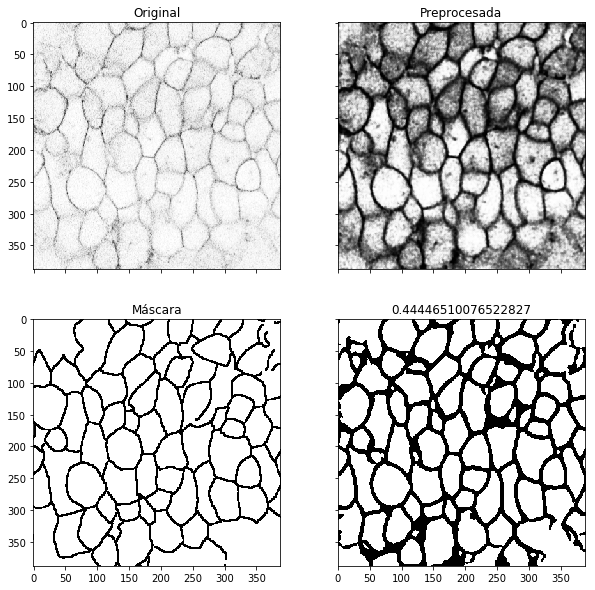

In [14]:
# Importar imágenes
img = cv2.imread('../pytorch-unet-segmentation-master/imagenes_pruebapre/0.png', cv2.IMREAD_GRAYSCALE)[r:r+h, c:c+w]
label = cv2.imread('../pytorch-unet-segmentation-master/imagenes_pruebapre/0_mask.png', cv2.IMREAD_UNCHANGED)[r:r+h, c:c+w, 3] == 0
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax[0, 0].imshow(img, cmap=plt.cm.Greys_r)
ax[0, 0].set_title('Original')
ax[1, 0].imshow(label, cmap=plt.cm.Greys_r)
ax[1, 0].set_title('Máscara')

# Preprocesamiento con opencv
#img = cv2.fastNlMeansDenoising(img, None, 5, 7, 21)
#img = cv2.medianBlur(img, 3)
img = cv2.bilateralFilter(img, 5, 75, 75)
img = cv2.equalizeHist(img)
ax[0, 1].imshow(img, cmap=plt.cm.Greys_r)
ax[0, 1].set_title('Preprocesada')

# Transformar con torch
im_pil = Image.fromarray(img)
img_tensor = my_transforms(im_pil)
#label_tensor = torch.from_numpy(label.astype('int'))
label_tensor = torch.from_numpy(label.astype('int64'))
# Evaluar con U-net
with torch.no_grad():
    output = model.forward(img_tensor.unsqueeze(0))

    loss = criterion(output, label_tensor.unsqueeze(0)).item()
    preds = torch.argmax(output, dim=1).float().squeeze(0).numpy()

# POSTPROCESSING
# TODO
#preds = cv2.morphologyEx(preds, cv2.MORPH_DILATE, kernel=np.ones((3,3),np.uint8), iterations = 1)
ax[1, 1].imshow(preds , cmap=plt.cm.Greys_r)
ax[1, 1].set_title(str(loss));